In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
non_manual = pd.read_csv("experiments/data.csv")
manual = pd.read_csv("experiments/manual.csv")
df = pd.concat([non_manual, manual], ignore_index=True)
df.rename(columns={ "runtime_[s]": "runtime" }, inplace=True)
mask = (df.n_procs == 1) & (df.n_threads == 1) & (~df.full_command.str.contains("manual"))
t_seq = df[mask].runtime.mean()
df["speedup"] = t_seq / df.runtime
df["ram"] = df["peakRSS_[KiB]"] * 1024 / 10**9 # ram in GB
df.head()

,peakRSS_[KiB],runtime,n_procs,n_threads,n_sites,n_taxa,n_alignments,omp_alg,full_command,datetime_of_run,speedup,ram
0,262460,1037.268,1,1,6000,200000,48,IM,iqtree2 --alisim output/alg -m GTR+I{0.2}+G4{0...,Wed Sep 3 21:16:18 UTC 2025,1.001601,0.268759
1,530552,728.070,2,1,6000,200000,48,IM,mpirun -np 2 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:33:38 UTC 2025,1.426963,0.543285
2,1063400,368.202,4,1,6000,200000,48,IM,mpirun -np 4 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:45:50 UTC 2025,2.821627,1.088922
3,2130072,212.496,8,1,6000,200000,48,IM,mpirun -np 8 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:52:01 UTC 2025,4.889168,2.181194
4,3199756,185.473,12,1,6000,200000,48,IM,mpirun -np 12 --allow-run-as-root iqtree2-mpi ...,Wed Sep 3 21:55:37 UTC 2025,5.601509,3.276550


In [3]:
upper = 200000
lower = 6000
assert ((df.n_sites == upper) | (df.n_sites == lower)).all()
assert ((df.n_taxa == upper) | (df.n_taxa == lower)).all()

In [11]:
df_mpi = df.iloc[:12]
df_omp_IM= df.iloc[12:24]
df_omp_EM = df.iloc[24:36]
df_hpc = df.iloc[36:56]
df_manual = df[df.full_command.str.contains("manual")]

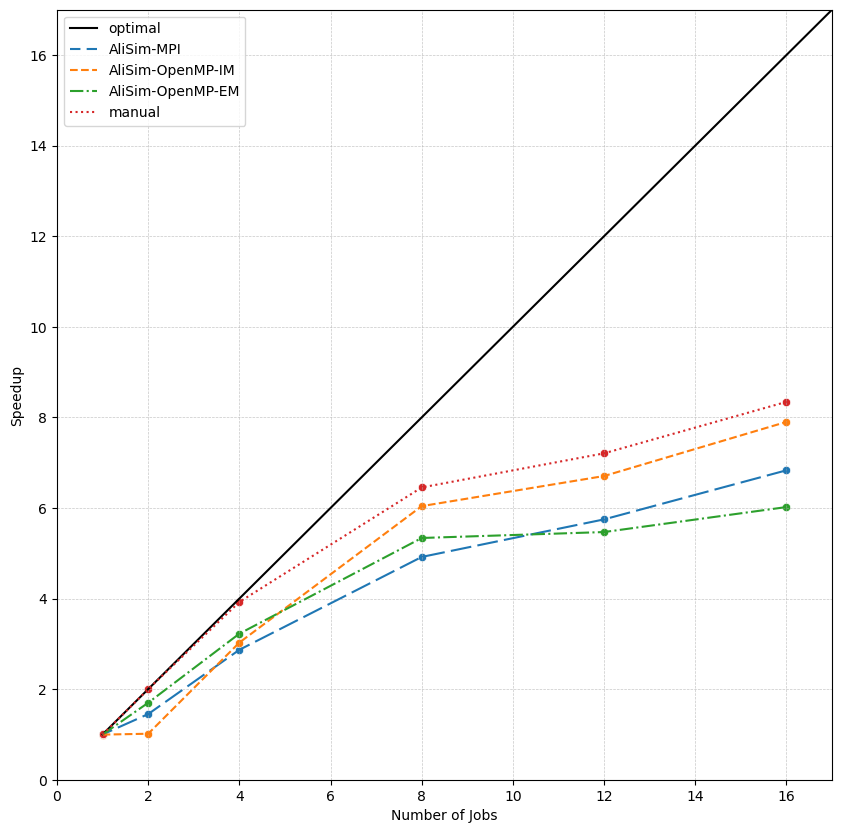

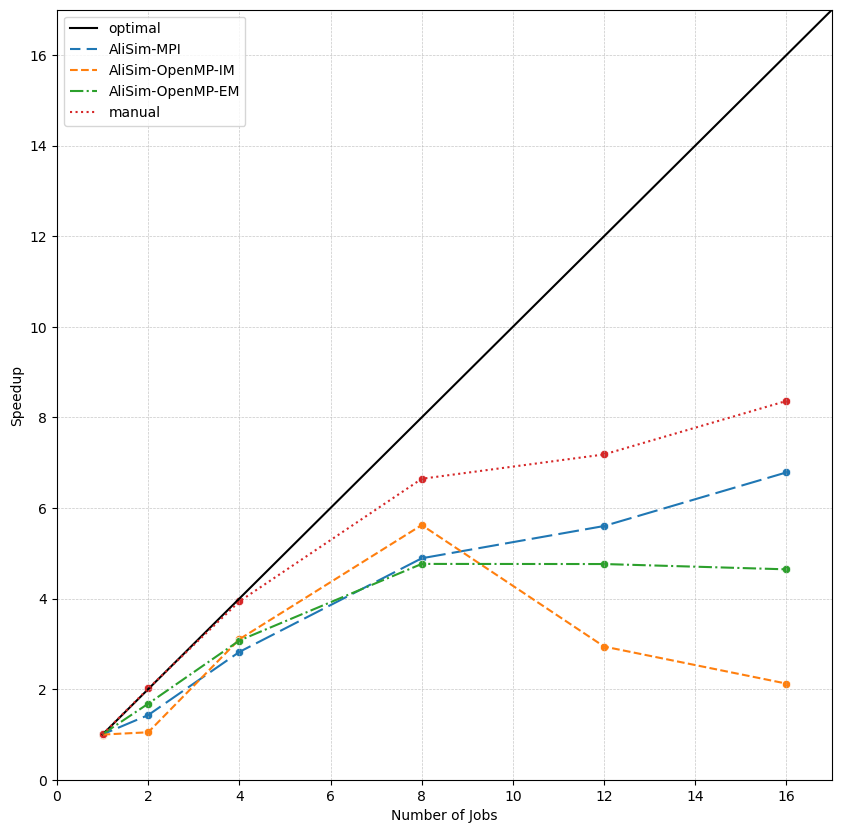

In [5]:
# figure 5
def speedup_plot(alg_type, fname=None):
    if alg_type == 'long':
        mask_value = upper
    elif alg_type == 'deep':
        mask_value = lower
    else:
        raise ValueError('alg_type should be either "long" or "deep"')
    figure_size = (10, 10)
    fig = plt.figure(figsize=figure_size)
    
    # Customize axis limits (optional)
    margin = 1
    val_range = (0, 16+margin)
    plt.xlim(val_range)   # x-axis range
    plt.ylim(val_range)
    
    # Add labels and title
    plt.xlabel("Number of Jobs")
    plt.ylabel("Speedup")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)  # light grid
    
    sns.lineplot(x=[1, 16+margin], y=[1, 16+margin], label='optimal', color="black")

    y_field = 'speedup'

    iter = [
        #format : dataframe, line_label, xvalue, linecolor, linestyle
        (df_mpi, 'AliSim-MPI', 'n_procs', 'tab:blue', (5, (10, 3))),
        (df_omp_IM, 'AliSim-OpenMP-IM', 'n_threads', 'tab:orange', '--'),
        (df_omp_EM, 'AliSim-OpenMP-EM', 'n_threads', 'tab:green', '-.'),
        (df_manual, 'manual', 'n_procs', 'tab:red', ':')
    ]
    
    for data, label, field, color, linestyle in iter:
        data_tmp = data[data.n_sites == mask_value]
        sns.lineplot(x=data_tmp[field], y=data_tmp[y_field], label=label, color=color, linestyle=linestyle)
        sns.scatterplot(x=data_tmp[field], y=data_tmp[y_field], color=color)
    
    plt.legend()
    if fname is not None:
        plt.savefig(fname)
    plt.show()

speedup_plot('long', 
             #"speedup_long.png"
            )
speedup_plot('deep',
             # "speedup_deep.png"
            )

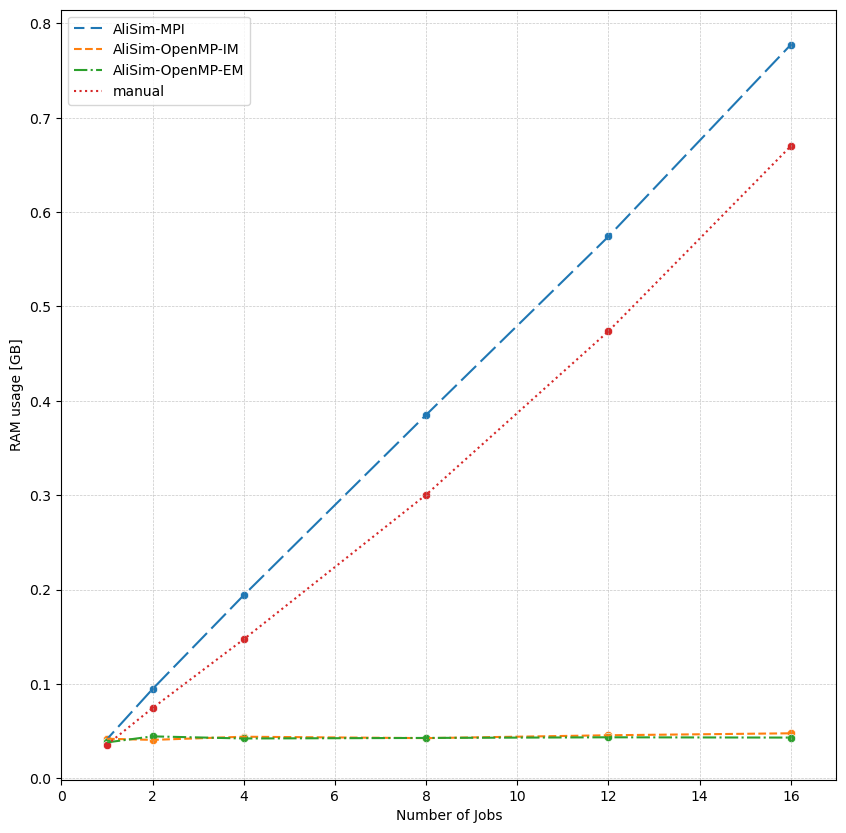

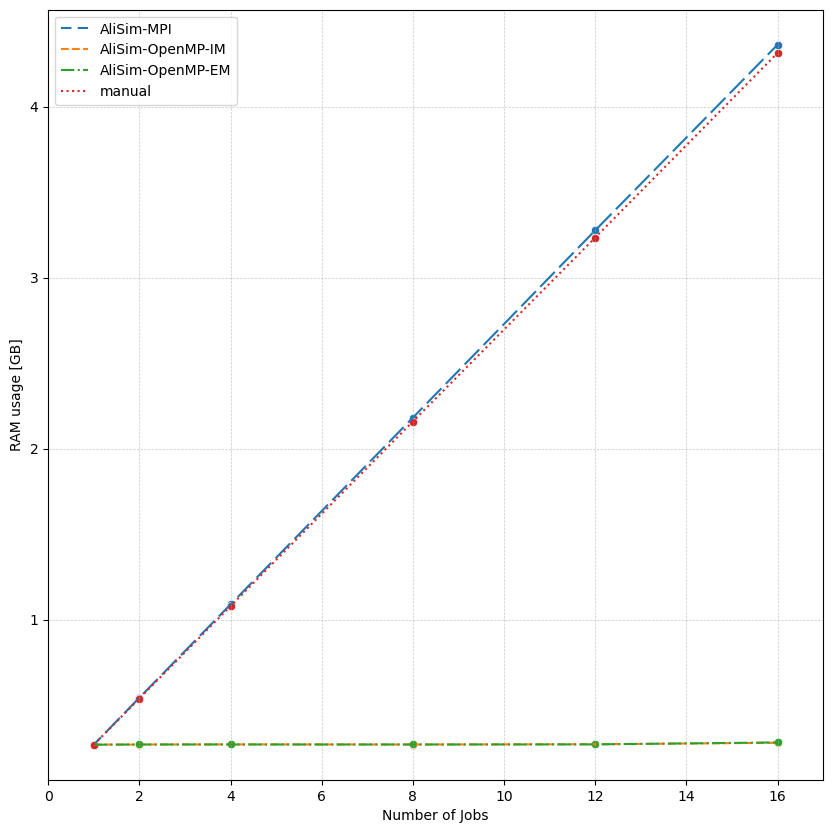

In [7]:
def ram_plot(alg_type, fname=None):
    if alg_type == 'long':
        mask_value = upper
    elif alg_type == 'deep':
        mask_value = lower
    else:
        raise ValueError('alg_type should be either "long" or "deep"')
    figure_size = (10, 10)
    fig = plt.figure(figsize=figure_size)
    
    # Customize axis limits (optional)
    margin = 1
    val_range = (0, 16+margin)
    plt.xlim(val_range)   # x-axis range
    
    # Add labels and title
    plt.xlabel("Number of Jobs")
    plt.ylabel("RAM usage [GB]")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)  # light grid
    
    y_field = 'ram'
    
    iter = [
        #format : dataframe, line_label, xvalue, linecolor, linestyle
        (df_mpi, 'AliSim-MPI', 'n_procs', 'tab:blue', (5, (10, 3))),
        (df_omp_IM, 'AliSim-OpenMP-IM', 'n_threads', 'tab:orange', '--'),
        (df_omp_EM, 'AliSim-OpenMP-EM', 'n_threads', 'tab:green', '-.'),
        (df_manual, 'manual', 'n_procs', 'tab:red', ':')
    ]
    
    for data, label, field, color, linestyle in iter:
        data_tmp = data[data.n_sites == mask_value]
        sns.lineplot(x=data_tmp[field], y=data_tmp[y_field], label=label, color=color, linestyle=linestyle)
        sns.scatterplot(x=data_tmp[field], y=data_tmp[y_field], color=color)
    
    plt.legend()
    if fname is not None:
        plt.savefig(fname)
    plt.show()

ram_plot('long', 
        # "ram_long.png"
        )
ram_plot('deep',
        # "ram_deep.png"
        )

In [33]:
cols = ("omp_alg","n_procs", "n_threads", "ram", "speedup")
hpc_long = df_hpc[df_hpc.n_sites == upper].loc[:,cols].round(4)
hpc_deep = df_hpc[df_hpc.n_sites == lower].loc[:,cols].round(4)

print("long")
print(hpc_long)
print("deep")
print(hpc_deep)

long
   omp_alg  n_procs  n_threads     ram  speedup
41      IM        1         16  0.0482   7.8481
42      IM        2          8  0.0951   6.2941
43      IM        4          4  0.1882   5.4549
44      IM        8          2  0.3843   3.5714
45      IM       16          1  0.7776   6.7875
51      EM        1         16  0.0408   5.9964
52      EM        2          8  0.0998   5.0312
53      EM        4          4  0.1872   4.9174
54      EM        8          2  0.3667   4.8180
55      EM       16          1  0.7355   6.9617
deep
   omp_alg  n_procs  n_threads     ram  speedup
36      IM        1         16  0.2795   2.1273
37      IM        2          8  0.5506   5.7925
38      IM        4          4  1.1007   5.2463
39      IM        8          2  2.2035   3.4628
40      IM       16          1  4.4117   6.7845
46      EM        1         16  0.2820   4.7054
47      EM        2          8  0.5535   5.1420
48      EM        4          4  1.1043   4.9909
49      EM        8          2